In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
try :
  import torchinfo
except :
  !pip install torchinfo
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from IPython.display import clear_output
np.float64()
try :
  from torch.utils.tensorboard import SummaryWriter
except :
  !pip install tensorboard

from torch.utils.tensorboard import SummaryWriter
from mpl_toolkits.mplot3d import Axes3D

# Data

In [38]:
from math import exp
# function to approach

"""def f(x,y):
  return torch.sqrt(1+x)*torch.sqrt(1+y)"""

def f(x, y, alpha=0.3, eps=0.01):
    return (x + eps)**alpha * (y + eps)**alpha


In [39]:
###############################################################     here is the data part

BATCH_SIZE = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

torch.manual_seed(42)

noise_std = 0.05

data = torch.linspace(0, 1, steps=100)
X, Y = torch.meshgrid(data, data, indexing="ij")
data = torch.stack([X.flatten(), Y.flatten()], dim=1)
x_values, y_values = data[:, 0], data[:, 1]

z_values = f(x_values, y_values) + noise_std * torch.randn_like(x_values)

dataset = TensorDataset(data, z_values.unsqueeze(1))  # Ajoute une dimension pour correspondre à (N, 1)

# Séparez le dataset en ensembles d'entraînement et de test
TRAIN_SIZE = int(0.8 * len(dataset))
TEST_SIZE = len(dataset) - TRAIN_SIZE
train_dataset, test_dataset = random_split(dataset, [TRAIN_SIZE, TEST_SIZE])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


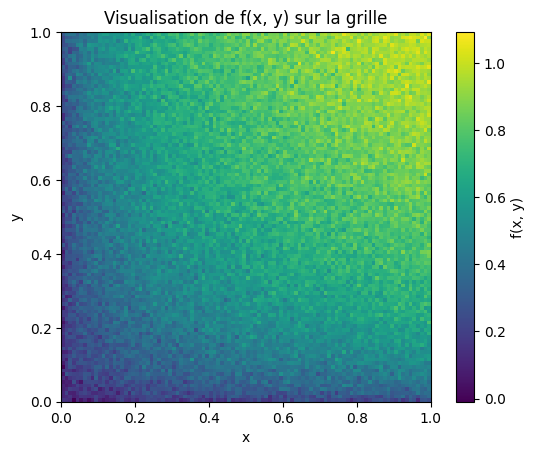

In [40]:


# Reshape z_values pour correspondre à la grille (1000, 1000)
Z = z_values.reshape(100, 100)

# Afficher Z sous forme d'image
plt.imshow(Z.numpy(), extent=(0, 1, 0, 1), origin='lower', cmap='viridis')
plt.colorbar(label="f(x, y)")
plt.title("Visualisation de f(x, y) sur la grille")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


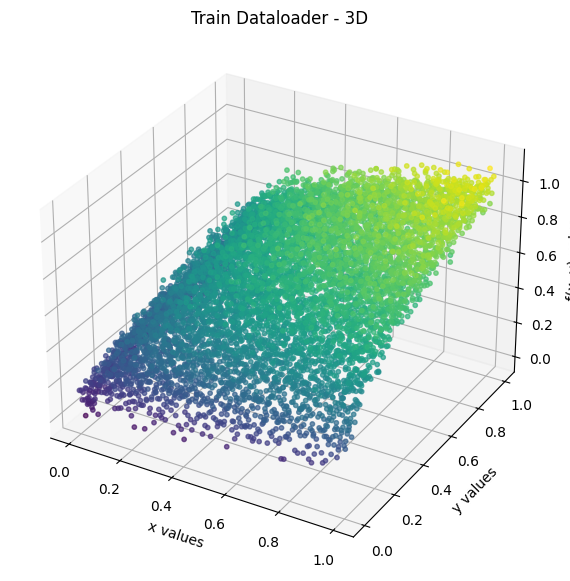

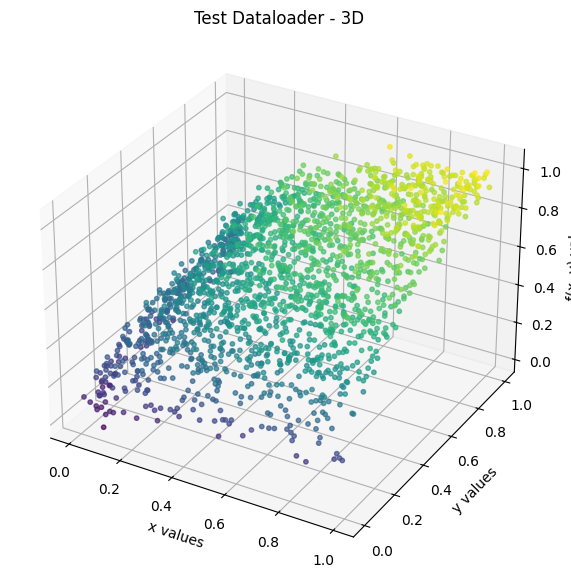

In [41]:

def visualize_dataloader_3d(dataloader, title):
    x_vals, y_vals, z_vals = [], [], []
    for x, y in dataloader:
        x_vals.append(x[:, 0].flatten())
        y_vals.append(x[:, 1].flatten())
        z_vals.append(y.flatten())


    x_vals = torch.cat(x_vals).numpy()
    y_vals = torch.cat(y_vals).numpy()
    z_vals = torch.cat(z_vals).numpy()


    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')


    ax.scatter(x_vals, y_vals, z_vals, c=z_vals, cmap='viridis', s=10, alpha=0.7)
    ax.set_xlabel("x values")
    ax.set_ylabel("y values")
    ax.set_zlabel("f(x, y) values")
    ax.set_title(title)
    plt.show()


visualize_dataloader_3d(train_dataloader, "Train Dataloader - 3D")


visualize_dataloader_3d(test_dataloader, "Test Dataloader - 3D")


# Model

In [42]:
class NN1(nn.Module):

  def __init__(self, in_features = 2, hidden_features = 16, out_features = 1):
    super().__init__()

    self.Linear1 = nn.Linear(in_features = in_features, out_features = hidden_features)
    self.Linear2 = nn.Linear(in_features = hidden_features, out_features = out_features)


  def forward(self, x):
    x = self.Linear2(torch.sigmoid(self.Linear1((x))))
    return x

class NN2(nn.Module):
  def __init__(self, in_features = 2, hidden_features = 16, out_features = 1):
    super().__init__()

    self.W1 = nn.Parameter(torch.randn(hidden_features, in_features)+1)
    self.b1 = nn.Parameter(torch.zeros(hidden_features))

    self.W2 = nn.Parameter(torch.randn(out_features, hidden_features))
    self.b2 = nn.Parameter(torch.zeros(out_features))


  def forward(self, x):
    pos_w1 = F.softplus(self.W1)
    pos_w2 = F.softplus(self.W2)
    a = torch.sigmoid(F.linear(x,pos_w1,self.b1))
    x = F.linear(a,pos_w2,self.b2)
    return x

class NN3(nn.Module):
  def __init__(self, in_features = 2, hidden_features = 16, out_features = 1):
    super().__init__()

    self.W1 = nn.Parameter(torch.randn(hidden_features, in_features)+1)
    self.b1 = nn.Parameter(torch.zeros(hidden_features))

    self.W2 = nn.Parameter(torch.randn(out_features, hidden_features))
    self.b2 = nn.Parameter(torch.zeros(out_features))
    self.relu = nn.ReLU()


  def forward(self, x):
    pos_w1 = F.softplus(self.W1)
    pos_w2 = F.softplus(self.W2)
    a = self.relu(F.linear(x,pos_w1,self.b1))
    x = F.linear(a,pos_w2,self.b2)
    return x

class NN4(nn.Module):
  def __init__(self, in_features = 2, hidden_features = 16, out_features = 1):
    super().__init__()

    self.W1 = nn.Parameter(torch.randn(hidden_features, in_features)+1)
    self.b1 = nn.Parameter(torch.zeros(hidden_features))

    self.W2 = nn.Parameter(torch.randn(out_features, hidden_features))
    self.b2 = nn.Parameter(torch.zeros(out_features))


  def forward(self, x):
    pos_w1, pos_w2 = self.W1 ** 2, self.W2 ** 2
    a = torch.sigmoid(F.linear(x,pos_w1,self.b1))
    x = F.linear(a,pos_w2,self.b2)
    return x

In [43]:
model1 = NN1(in_features = 2, hidden_features = 16, out_features = 1).to(device)
model2 = NN2(in_features = 2, hidden_features = 16, out_features = 1).to(device)
model3 = NN3(in_features = 2, hidden_features = 16, out_features = 1).to(device)
model4 = NN4(in_features = 2, hidden_features = 16, out_features = 1).to(device)

# Train

In [44]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 1. do the forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    train_loss = train_loss / len(dataloader)
    return train_loss

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    model.eval()
    test_loss = 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    return test_loss


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    results = {"train_loss": [],
               "test_loss": [],
    }




    model.to(device)

    for epoch in tqdm(range(epochs), desc = "Training progress"):
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)
        test_loss  = test_step(model=model,
                              dataloader=test_dataloader,
                              loss_fn=loss_fn,
                              device=device)


        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")


        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    # Plotting outside the loop
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(range(1, epochs + 1), results["train_loss"], label="Train Loss")
    ax.plot(range(1, epochs + 1), results["test_loss"], label="Test Loss")

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Training and Testing Loss over Epochs (log scale)")
    ax.set_yscale("log")
    ax.legend()
    ax.grid(True)
    plt.show()




    return results

# Engine


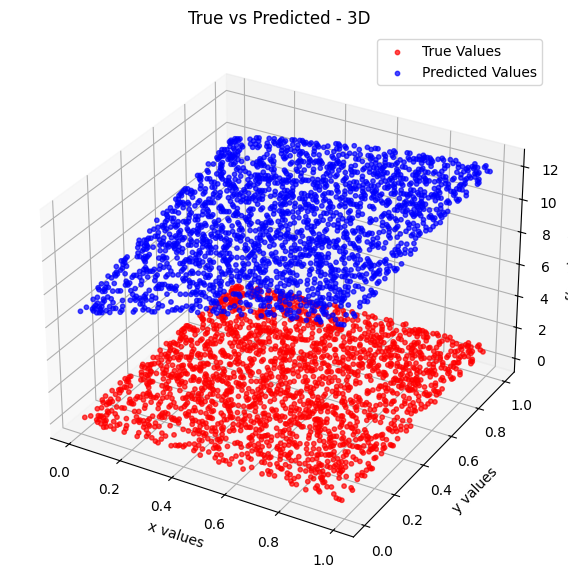

In [45]:
def visualize_true_pred(model, dataloader, title, device="cpu"):
    model.eval()
    x_vals, y_vals, true_vals, pred_vals = [], [], [], []
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)

            pred = model(X)


            x_vals.append(X[:, 0].flatten())
            y_vals.append(X[:, 1].flatten())
            true_vals.append(y.flatten())
            pred_vals.append(pred.flatten())

    x_vals = torch.cat(x_vals).cpu().numpy()
    y_vals = torch.cat(y_vals).cpu().numpy()
    true_vals = torch.cat(true_vals).cpu().numpy()
    pred_vals = torch.cat(pred_vals).cpu().numpy()

    sorted_indices = np.lexsort((y_vals, x_vals))
    x_vals = x_vals[sorted_indices]
    y_vals = y_vals[sorted_indices]
    true_vals = true_vals[sorted_indices]
    pred_vals = pred_vals[sorted_indices]

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x_vals, y_vals, true_vals, c='r', label="True Values", alpha=0.7, s=10)


    ax.scatter(x_vals, y_vals, pred_vals, c='b', label="Predicted Values", alpha=0.7, s=10)

    ax.set_xlabel("x values")
    ax.set_ylabel("y values")
    ax.set_zlabel("f(x, y) values")
    ax.set_title(title)
    ax.legend()
    plt.show()


visualize_true_pred(model2, test_dataloader, "True vs Predicted - 3D", device="cpu")


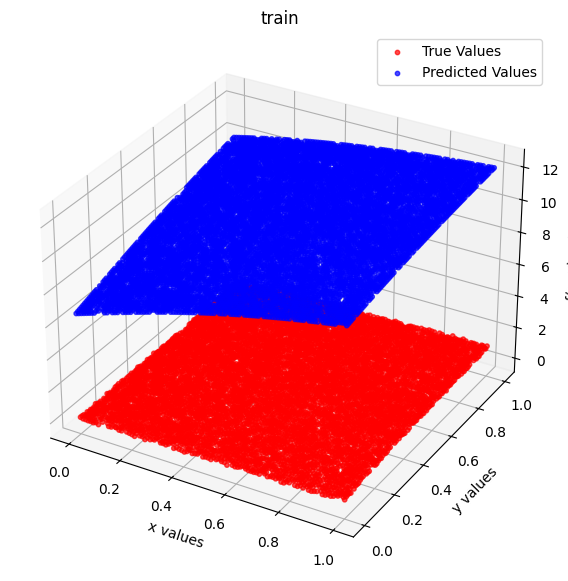

In [46]:
visualize_true_pred(model2, train_dataloader, "train")

In [47]:
# Ridge regularization
my_optimizer2 = torch.optim.AdamW(params=model2.parameters(), lr=0.05, weight_decay=1e-4)
my_loss_fn = nn.MSELoss()

In [ ]:
results = train(model = model2,
          train_dataloader = train_dataloader,
          test_dataloader = test_dataloader,
          optimizer = my_optimizer2,
          loss_fn = my_loss_fn,
          epochs = 400,
          device = device)

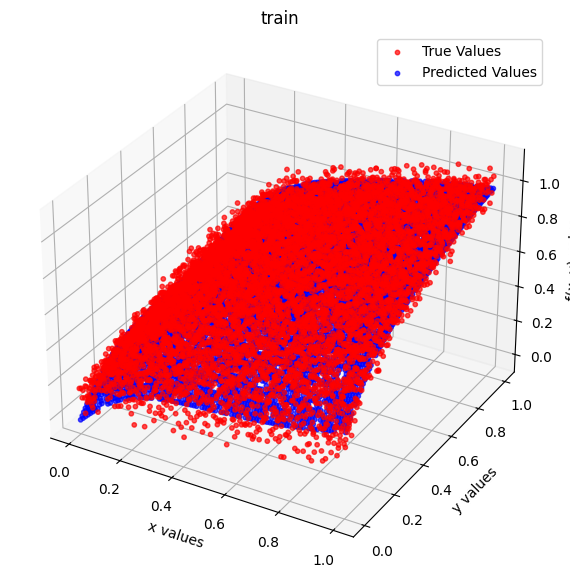

In [51]:
visualize_true_pred(model2, train_dataloader, "train")